In [1]:
%matplotlib inline

# ensure that any edits to libraries
# are reloaded automatically
%reload_ext autoreload
%autoreload 2

In [2]:
# make survos2 importable
import sys
sys.path.append("./..")

lets import the relavent functions

In [3]:
from cuda_slic.slic import slic as cuda_slic

In [4]:
import numpy as np
from skimage import data, color, filters, segmentation
from skimage.util import img_as_float32, img_as_float64
from skimage.segmentation import slic as sk_slic
from skimage.segmentation import mark_boundaries

import matplotlib.pyplot as plt
from ipywidgets import interact


In [5]:
# 3D muli-channel
import h5py as h5
with h5.File('../data/brain.h5', 'r') as f:
    brain = f['/data'][()]
#labels = cuda_slic(brain, n_segments=10000, multichannel=False, compactness=1)
labels = sk_slic(brain, n_segments=10000, multichannel=False, compactness=0.02, slic_zero=True)

plt.figure(figsize=(20,20))
plt.imshow(labels[40])
plt.show()

ModuleNotFoundError: No module named 'h5py'

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85]


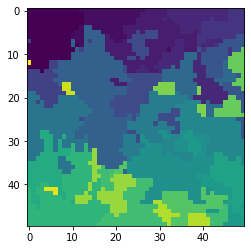

In [6]:
vol = data.binary_blobs(length=50, n_dim=4, seed=33)[...]
labels = cuda_slic(vol, n_segments=100, multichannel=True, compactness=1)
print(np.unique(labels))
plt.imshow(labels[5])

Comparing speed between cuda-slic and skslic

cuda_slic took:
527 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
sk_slic took:


/scratch/ovs72384/anaconda3/envs/cupy-slic/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  """Entry point for launching an IPython kernel.


1.25 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/scratch/ovs72384/anaconda3/envs/cupy-slic/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

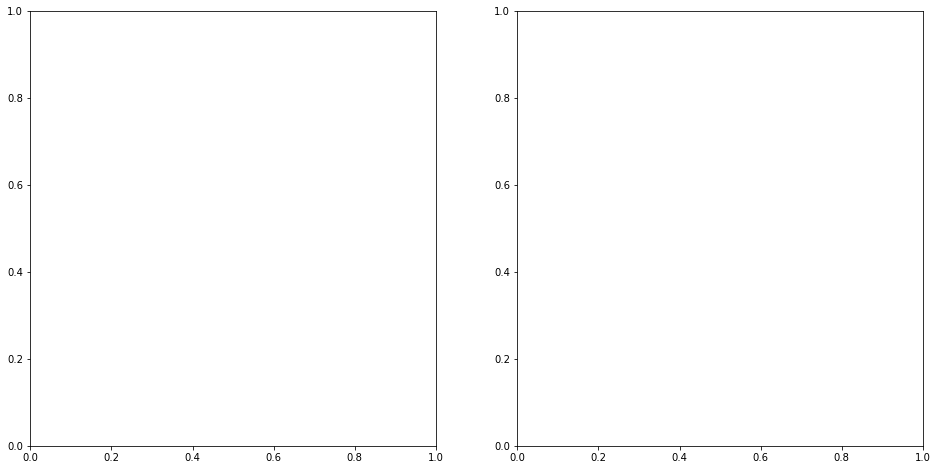

In [7]:
# initializing a 3 dim dataset

blob = data.binary_blobs(length=100, n_dim=3, seed=2)
blob = np.float32(blob)


print("cuda_slic took:")
%timeit -n1 -r1 cuda_labels = cuda_slic(blob, n_segments=300**2, compactness=0.5)
cuda_labels = cuda_slic(blob, n_segments=200, compactness=.5)

#blob = img_as_float64(blob)
print("sk_slic took:")
%timeit -n1 -r1 sk_labels = sk_slic(blob, n_segments=200, compactness=.5,  multichannel=False)
sk_labels = sk_slic(blob, n_segments=200, compactness=1,  multichannel=False)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
ax1.imshow(cuda_labels[:,:,0]); ax1.axis("off"); ax1.set_title("cuda labels", size=22);
ax2.imshow(sk_labels[...,0]); ax2.axis("off"); ax2.set_title("sk labels", size=22);

lets explore the segmentation of the whole 3D array

In [8]:
marked_cuda = mark_boundaries(color.gray2rgb(blob), cuda_labels)
marked_sk = mark_boundaries(color.gray2rgb(blob), sk_labels)

In [9]:
def plot_slice(images, z, cols=2, ax_size=5, titles=None):
    rows = (len(images)+cols-1)//cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*ax_size, rows*ax_size))
    axes = axes.flatten()
    for ax in axes:
        ax.axis('off')
    for i in range(len(images)):
        axes[i].imshow(images[i][:,:,z])
        if titles:
            axes[i].set_title(titles[i], size=32)
    plt.tight_layout()

interactive(children=(IntSlider(value=0, description='z', max=99), IntSlider(value=2, description='cols', max=…

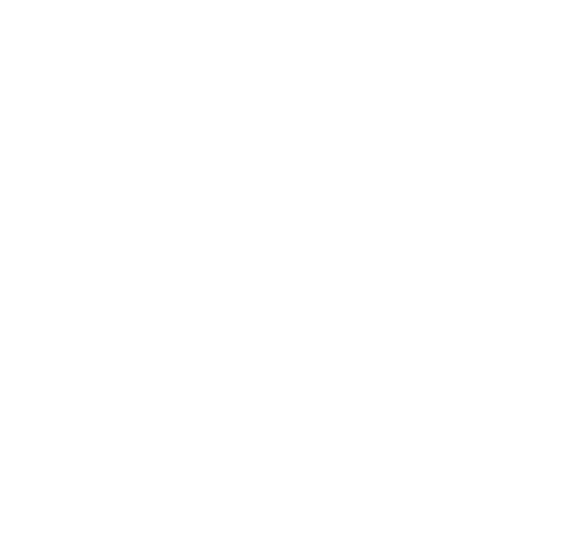

In [10]:
from ipywidgets import IntSlider, fixed
interact(plot_slice,
         images=fixed([cuda_labels, marked_cuda, sk_labels, marked_sk]),
         titles=fixed(None),
         z=IntSlider(min=0, max=99),
         ax_size=(2,20),
         cols=(1,6));

exploring the `n_segments` parameter and `compactness` parameter for cuda_slic and sk_slic

In [11]:
blob = data.binary_blobs(length=8, n_dim=3, seed=2)
#blob = filters.gaussian(blob)
blob = blob[:,:,:5]
#blob = filters.gaussian(blob)
blob = np.float32(blob)
print(blob)

[[[1. 1. 0. 0. 0.]
  [1. 1. 1. 0. 0.]
  [1. 1. 1. 0. 0.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [0. 1. 0. 0. 1.]
  [0. 0. 1. 1. 1.]]

 [[0. 0. 0. 0. 1.]
  [1. 0. 1. 1. 0.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 0. 0. 1. 1.]
  [1. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 1.]]

 [[0. 0. 0. 0. 0.]
  [1. 0. 1. 1. 0.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 0. 0. 0. 1.]
  [1. 1. 0. 0. 1.]
  [1. 1. 1. 0. 0.]
  [0. 0. 0. 1. 1.]]

 [[0. 0. 0. 0. 0.]
  [1. 1. 1. 1. 0.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0.]
  [1. 1. 0. 0. 1.]
  [1. 0. 0. 1. 1.]]

 [[1. 0. 0. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 1.]]

 [[0. 1. 1. 1. 1.]
  [1. 1. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [1. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 1.]
  [0. 0. 0. 1. 1.]]

 [[0. 1. 1. 1. 1.]
  [0. 0. 0. 0. 1.]
  [0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0.]


In [12]:
def compare_slic_algos(cuda_c, sk_c, max_iter=5, n_segments=100, z=0):
    cuda_labels = cuda_slic(blob, n_segments=n_segments,
                            compactness=cuda_c,
                            max_iter=max_iter,
                            postprocess=False)
    sk_labels = sk_slic(blob, n_segments=n_segments,
                        compactness=sk_c,
                        multichannel=False,
                        start_label=1)
    marked_blob_cuda = mark_boundaries(color.gray2rgb(blob), cuda_labels, color=(0.2, 1, 0))
    marked_blob_sk = mark_boundaries(color.gray2rgb(blob), sk_labels, color=(1, 0.7, 0))
    plot_slice([cuda_labels, blob, sk_labels, blob],
               z=z,
               ax_size=6,
               titles=["cuda-slic", "data", "skimage-slic", "data"])
    print("cuda unique labels = {}".format(len(np.unique(cuda_labels))))
    print("sk unique labels = {}".format(len(np.unique(sk_labels))))

In [13]:
interact(compare_slic_algos,
         cuda_c=(0.001,1.0,0.001),
         sk_c=(0.001,1.0,0.0001),
         n_segments=(0,500),
         z=IntSlider(min=0, max=9));

interactive(children=(FloatSlider(value=0.5, description='cuda_c', max=1.0, min=0.001, step=0.001), FloatSlide…

## Cuda SLIC Failiure Modes
From playing around with the parameters I was able to discover a few inputs that causes the cuda_slic algorithm to throw an error.

In [26]:
RUN_TESTS = True

### 1. input array (500, 500, 500), nps>50_000, compactness=30:

This usually throughs a `LogicError` exception. When it fails, it leaves memory residue in the GPU that is not cleaned up unless you terminate the pyhton process. 

This error is sometimes generated from the cuda compilation step of the `ccl.py` and sometimes form `slic.py`

Further complicating things the algorithm does not fail reliably with these inputs!!
However, I was able to make it fail reliably with `nps=500_000`. This indicates that the failiure rate is related to the the `nps` parameter.


In [32]:
if RUN_TESTS:
    blob = data.binary_blobs(length=600, n_dim=3, seed=2)
    blob = np.float32(blob)
    cuda_labels = cuda_slic(blob, n_segments=5_000_000, compactness=0.5)
    print(len(np.unique(cuda_labels)))

3338303



```
---------------------------------------------------------------------------
LogicError                                Traceback (most recent call last)
<ipython-input-39-ad381aadb072> in <module>
      1 blob = data.binary_blobs(length=500, n_dim=3, seed=2)
      2 blob = img_as_float32(blob)
----> 3 cuda_labels = cuda_slic(blob, nsp=50_000, compactness=30)
      4 print(len(np.unique(cuda_labels)))

~/Projects/gpu-slic/survos2/improc/utils.py in wrapper(out, src_mode, *args, **kwargs)
    563                          fillvalue=fillvalue, src_mode=src_mode)
    564         with DatasetManager(*args, **dm_params) as DM:
--> 565             result = func(*DM.sources, **kwargs)
    566             if out is not None:
    567                 DM.out[...] = result

~/Projects/gpu-slic/survos2/improc/cuda.py in wrapper(keep_gpu, *args, **kwargs)
     37     @wraps(func)
     38     def wrapper(*args, keep_gpu=False, **kwargs):
---> 39         r = func(*args, **kwargs)
     40         return asgpuarray(r, dtype) if keep_gpu else asnparray(r, dtype)
     41     return wrapper

~/Projects/gpu-slic/survos2/improc/regions/slic.py in slic3d(data, nsp, sp_shape, compactness, sigma, spacing, max_iter, postprocess)
     29 
     30     with open(op.join(__dirname__, 'kernels', 'slic3d.cu'), 'r') as f:
---> 31         _mod_conv = SourceModule(f.read())
     32         gpu_slic_init = _mod_conv.get_function('init_clusters')
     33         gpu_slic_expectation = _mod_conv.get_function('expectation')

/scratch/ovs72384/anaconda3/envs/gpu-slic/lib/python3.7/site-packages/pycuda/compiler.py in __init__(self, source, nvcc, options, keep, no_extern_c, arch, code, cache_dir, include_dirs)
    292 
    293         from pycuda.driver import module_from_buffer
--> 294         self.module = module_from_buffer(cubin)
    295 
    296         self._bind_module()

LogicError: cuModuleLoadDataEx failed: an illegal memory access was encountered -
```

Interestingly, `sk_slic` drops out and refuses to segment the array to more than 250_000 groups. For example

In [20]:
sk_labels = sk_slic(blob, n_segments=5_000_000, compactness=1)
print(len(np.unique(sk_labels))) #250000

360000




### 2. input array of size less than (32, 32, 32) fails with "`IndexError`: too many indices for array"

In [28]:
if RUN_TESTS:
    blob = data.binary_blobs(length=32, n_dim=3, seed=2)
    blob = np.float32(blob)
    cuda_labels = cuda_slic(blob, n_segments=2, compactness=0.5)
    print(len(np.unique(cuda_labels)))

8


```
---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
<ipython-input-22-0316eb65c967> in <module>
      1 blob = data.binary_blobs(length=31, n_dim=3, seed=2)
      2 blob = img_as_float32(blob)
----> 3 cuda_labels = cuda_slic(blob, nsp=10, compactness=30)
      4 print(len(np.unique(cuda_labels)))

~/Projects/gpu-slic/survos2/improc/utils.py in wrapper(out, src_mode, *args, **kwargs)
    563                          fillvalue=fillvalue, src_mode=src_mode)
    564         with DatasetManager(*args, **dm_params) as DM:
--> 565             result = func(*DM.sources, **kwargs)
    566             if out is not None:
    567                 DM.out[...] = result

~/Projects/gpu-slic/survos2/improc/cuda.py in wrapper(keep_gpu, *args, **kwargs)
     37     @wraps(func)
     38     def wrapper(*args, keep_gpu=False, **kwargs):
---> 39         r = func(*args, **kwargs)
     40         return asgpuarray(r, dtype) if keep_gpu else asnparray(r, dtype)
     41     return wrapper

~/Projects/gpu-slic/survos2/improc/regions/slic.py in slic3d(data, nsp, sp_shape, compactness, sigma, spacing, max_iter, postprocess)
     85     if postprocess:
     86         min_size = int(np.prod(_sp_shape) / 10.)
---> 87         r = merge_small(asnparray(data), r, min_size)
     88         binlab = np.bincount(r.ravel())
     89 

~/Projects/gpu-slic/survos2/improc/utils.py in wrapper(out, src_mode, *args, **kwargs)
    563                          fillvalue=fillvalue, src_mode=src_mode)
    564         with DatasetManager(*args, **dm_params) as DM:
--> 565             result = func(*DM.sources, **kwargs)
    566             if out is not None:
    567                 DM.out[...] = result

~/Projects/gpu-slic/survos2/improc/utils.py in wrapper(*args, **kwargs)
    517     @wraps(func)
    518     def wrapper(*args, **kwargs):
--> 519         r = func(*args, **kwargs)
    520         return r is None or asnparray(r, dtype=dtype)
    521     return wrapper

~/Projects/gpu-slic/survos2/improc/regions/ccl.py in merge_small(data, labels, min_size, **kwargs)
     80         data = data[..., None]
     81     assert data.ndim == labels.ndim + 1
---> 82     return _merge_small3d(data, labels, labels.max()+1, min_size)
     83 
     84 

~/Projects/gpu-slic/survos2/improc/regions/_ccl.pyx in improc.superregions._ccl._merge_small3d()

IndexError: too many indices for array

```

In [27]:
## 3. lets check if the code is diterministic

In [66]:
if RUN_TESTS:
    blob = data.binary_blobs(length=10, n_dim=3, seed=2)
    blob = np.float32(blob)
    all_close = []
    for i in range(10):
        cuda_labels1 = cuda_slic(blob, n_segments=100, compactness=0.1, postprocess=False)
        cuda_labels2 = cuda_slic(blob, n_segments=100, compactness=0.1, postprocess=False)
        all_close.append((cuda_labels1 == cuda_labels2).all())
    print(all_close)

[True, True, True, True, True, True, True, True, True, True]


```
---------------------------------------------------------------------------
AssertionError                            Traceback (most recent call last)
<ipython-input-38-af438af83248> in <module>
      4 cuda_labels2 = cuda_slic(blob, nsp=32, compactness=30)
      5 
----> 6 assert np.allclose(cuda_labels1, cuda_labels2)

AssertionError: 
```

as expected. This basically confirms to me that there are memory race errors in the code.

This is likely related to Faliure mode 1. as you expect data races not to raise errors under
ordinary circomstances.

## Performance Benchmarks
Performance characteristics can reveal important bugs in the code base. So lets see how `cuda_slic` and `sk_slic` compare.

Running these benchmarks uncovered errors when the cuda_slic functin is run consecutively with many different inputs.
This indicates that the GPU memory is retaining state from previous calls that cause a subsequent kernel calls to fail.

Lets keep a record of this data:

In [5]:
from pathlib import Path

# make `data` directory in notebooks if it does not exist
notebooks = Path(".")
dir_name = str(notebooks.absolute()).split("/")[-1]
if dir_name == "notebooks":
    (notebooks/"benchmarks").mkdir(exist_ok=True)
else:
    print("notebooks is not your current worknig directory")
[print(f) for f in notebooks.iterdir()];

.ipynb_checkpoints
exploring_slic3d.ipynb
benchmarks
numpy_notes.ipynb
pycuda_debug.ipynb
exploring_skimage_slic.ipynb


In [5]:
import pandas as pd

In [12]:
DO_BENCHMARK = True
SAVE_BENCHMARK = False

def generate_benchmark():
    df = pd.DataFrame(columns=["bytes", "n_segments", "cuda_time", "skimage_time"])
    lengths = [100, 200, 300, 400, 500]
    #lengths = range(100, 450,30)
    for i in range(len(lengths)):
        row = []
        row.append(lengths[i]**3*4) #number of bytes to be processed
        n_segments = lengths[i]**3/3**3
        row.append(n_segments)
        blob = data.binary_blobs(length=lengths[i], n_dim=3, seed=2)
        blob = np.float32(blob)
        print(f"cuda time for length {lengths[i]}:")
        measurement1 = %timeit -n1 -r1 -o cuda_slic(blob, n_segments=n_segments, multichannel=False, compactness=1)
        row.append(measurement1.average)
        print(f"skimage time for length {lengths[i]}:")
        measurement2 = %timeit -n1 -r1 -o sk_slic(blob, n_segments=n_segments, \
                                                  compactness=1, multichannel=False, \
                                                  max_iter=5, start_label=1)
        row.append(measurement2.average)
        df.loc[i] = row
    return df
if DO_BENCHMARK:
    df = generate_benchmark()

cuda time for length 100:
523 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
skimage time for length 100:
1.12 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
cuda time for length 200:
464 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
skimage time for length 200:
9.51 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
cuda time for length 300:
1.51 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
skimage time for length 300:
32.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
cuda time for length 400:
3.48 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
skimage time for length 400:
1min 16s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
cuda time for length 500:
6.47 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
skimage time for length 500:
2min 31s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [13]:
print(df.skimage_time/df.cuda_time)

0     2.142904
1    20.495266
2    21.334586
3    21.925650
4    23.362116
dtype: float64


In [8]:
from datetime import datetime

d = datetime.now()
d.strftime("%d_%m_%Y")

'23_08_2020'

In [9]:
from datetime import datetime
SAVE_BENCHMARK = True
if SAVE_BENCHMARK:
    d = datetime.now()
    d = d.strftime("%d_%m_%Y")
    df.to_csv("benchmarks/slic_bench_{}.csv".format(d), index=False)

In [10]:
ndf = df.copy()

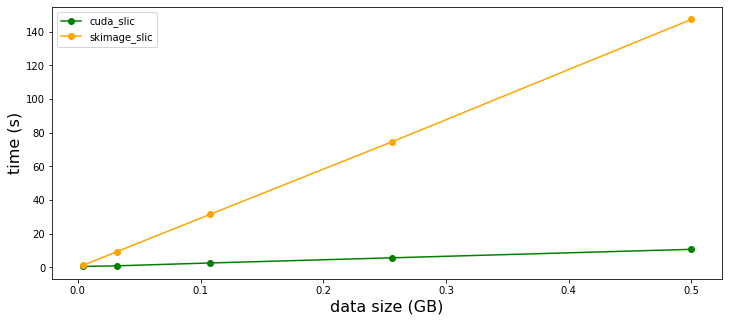

In [11]:
ndf["g_bytes"] = ndf["bytes"]/10**9

fig, ax = plt.subplots(1,1,figsize=(12,5))
plt.plot(ndf.g_bytes, ndf.cuda_time, color="green", marker="o", label="cuda_slic")

plt.plot(ndf.g_bytes, ndf.skimage_time, color="orange", marker="o", label="skimage_slic")
plt.xlabel("data size (GB)", size=16)
plt.ylabel("time (s)", size=16)
plt.legend()

In [12]:
slope_cuda = (ndf.cuda_time.iloc[-1] - ndf.cuda_time.iloc[0])/\
             (ndf.g_bytes.iloc[-1] - ndf.g_bytes.iloc[0])
slope_skimage = (ndf.skimage_time.iloc[-1] - ndf.skimage_time.iloc[0])/\
                (ndf.g_bytes.iloc[-1] - ndf.g_bytes.iloc[0])

In [13]:
print(slope_cuda);print(slope_skimage)

20.52296429821816
294.8413084776539


In [14]:
print("So cuda_slic is ~{:.2f}x faster than sk_slic.".format(slope_skimage/slope_cuda))

So cuda_slic is ~14.37x faster than sk_slic.


In [5]:
def cuda_benchmark():
    byte_sizes = []
    times = []
    lengths = range(100, 550,50)
    #lengths = [750]
    for i in range(len(lengths)):
        byte_size = lengths[i]**3*4
        byte_sizes.append(byte_size)
        n_segments = lengths[i]**3/10**3
        blob = data.binary_blobs(length=lengths[i], n_dim=3, seed=2)
        blob = np.float32(blob)
        print("input data now is {} MB".format(byte_size/10**6))
        measurement = %timeit -n1 -r1 -o cuda_slic(blob, n_segments=n_segments, compactness=1)
        times.append(measurement.average)
    return byte_sizes, times

b, t = cuda_benchmark()

input data now is 4.0 MB
795 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
input data now is 13.5 MB
664 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
input data now is 32.0 MB
1.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
input data now is 62.5 MB
2.09 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
input data now is 108.0 MB
3.74 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
input data now is 171.5 MB
5.51 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
input data now is 256.0 MB
8.11 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
input data now is 364.5 MB
11.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
input data now is 500.0 MB
19.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
print(b, t)
plt.plot([bb/10**9 for bb in b], t, color="green", marker="o")

### Profiling

In [15]:
!pip install line_profiler

     |████████████████████████████████| 68 kB 701 kB/s  eta 0:00:01


In [16]:
%load_ext line_profiler

In [17]:
# initializing a 3 dim dataset
n = 600
n_segments = n**3/5**3
blob = data.binary_blobs(length=n, n_dim=3, seed=2)
blob = np.float32(blob)

In [19]:

%lprun -f cuda_slic cuda_slic(blob, n_segments=n_segments, multichannel=False, compactness=0.5)

<pre>



Timer unit: 1e-06 s

Total time: 40.0355 s
File: /home/ovs72384/Projects/cuda-slic/src/cuda_slic/slic.py
Function: slic at line 26

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    26                                           def slic(
    27                                               image,
    28                                               n_segments=100,
    29                                               compactness=1.0,
    30                                               spacing=(1, 1, 1),
    31                                               max_iter=5,
    32                                               multichannel=True,
    33                                               convert2lab=None,
    34                                               enforce_connectivity=True,
    35                                               min_size_factor=0.4,
    36                                               max_size_factor=10.0,
    37                                           ):
    38                                               """Segments image using k-means clustering in Color-(x,y,z) space.
    39                                               Parameters
    40                                               ----------
    41                                               image : 2D, 3D or 4D ndarray
    42                                                   Input image, which can be 2D or 3D, and grayscale or multichannel
    43                                                   (see `multichannel` parameter).
    44                                               n_segments : int, optional
    45                                                   The (approximate) number of labels in the segmented output image.
    46                                               compactness : float, optional
    47                                                   Balances color proximity and space proximity. Higher values give
    48                                                   more weight to space proximity, making superpixel shapes more
    49                                                   square/cubic.
    50                                                   This parameter depends strongly on image contrast and on the
    51                                                   shapes of objects in the image. We recommend exploring possible
    52                                                   values on a log scale, e.g., 0.01, 0.1, 1, 10, 100, before
    53                                                   refining around a chosen value.
    54                                               max_iter : int, optional
    55                                                   Maximum number of iterations of k-means.
    56                                               spacing : (3,) array-like of floats, optional
    57                                                   The voxel spacing along each image dimension. By default, `slic`
    58                                                   assumes uniform spacing (same voxel resolution along z, y and x).
    59                                                   This parameter controls the weights of the distances along z, y,
    60                                                   and x during k-means clustering.
    61                                               multichannel : bool, optional
    62                                                   Whether the last axis of the image is to be interpreted as multiple
    63                                                   channels or another spatial dimension.
    64                                               convert2lab : bool, optional
    65                                                   Whether the input should be converted to Lab colorspace prior to
    66                                                   segmentation. The input image *must* be RGB. Highly recommended.
    67                                                   This option defaults to ``True`` when ``multichannel=True`` *and*
    68                                                   ``image.shape[-1] == 3``.
    69                                               enforce_connectivity : bool, optional
    70                                                   Whether the generated segments are connected or not
    71                                               min_size_factor : float, optional
    72                                                   Proportion of the minimum segment size to be removed with respect
    73                                                   to the supposed segment size ```depth*width*height/n_segments```
    74                                               max_size_factor : float, optional
    75                                                   Proportion of the maximum connected segment size. A value of 3 works
    76                                                   in most of the cases.
    77                                               Returns
    78                                               -------
    79                                               labels : 2D or 3D array
    80                                                   Integer mask indicating segment labels.
    81                                               Raises
    82                                               ------
    83                                               ValueError
    84                                                   If ``convert2lab`` is set to ``True`` but the last array
    85                                                   dimension is not of length 3.
    86                                               ValueError
    87                                                   If ``image.ndim`` is not 2, 3 or 4.
    88                                               Notes
    89                                               -----
    90                                               * Images of shape (M, N, 3) are interpreted as 2D RGB images by default. To
    91                                                 interpret them as 3D with the last dimension having length 3, use
    92                                                 `multichannel=False`.
    93                                           
    94                                               References
    95                                               ----------
    96                                               .. [1] Radhakrishna Achanta, Appu Shaji, Kevin Smith, Aurelien Lucchi,
    97                                                   Pascal Fua, and Sabine Süsstrunk, SLIC Superpixels Compared to
    98                                                   State-of-the-art Superpixel Methods, TPAMI, May 2012.
    99                                                   :DOI:`10.1109/TPAMI.2012.120`
   100                                               Examples
   101                                               --------
   102                                               >>> from cuda_slic import slic
   103                                               >>> from skimage import data
   104                                               >>> img = data.astronaut() # 2D RGB image
   105                                               >>> labels = slic(img, n_segments=100, compactness=10)
   106                                               To segment single channel 3D volumes
   107                                               >>> vol = data.binary_blobs(length=50, n_dim=3, seed=2)
   108                                               >>> labels = slic(vol, n_segments=100, multichannel=False, compactness=0.1)
   109                                               """
   110                                           
   111         1          7.0      7.0      0.0      if image.ndim not in [2, 3, 4]:
   112                                                   raise ValueError(
   113                                                       (
   114                                                           "input image must be either 2, 3, or 4 dimentional.\n"
   115                                                           "The input image.ndim is {}".format(image.ndim)
   116                                                       )
   117                                                   )
   118                                           
   119         1          3.0      3.0      0.0      is_2d = False
   120                                           
   121         1          2.0      2.0      0.0      if image.ndim == 2:
   122                                                   # 2D grayscale image
   123                                                   image = image[np.newaxis, ..., np.newaxis]
   124                                                   is_2d = True
   125         1          3.0      3.0      0.0      elif image.ndim == 3 and multichannel:
   126                                                   # Make 2D multichannel image 3D with depth = 1
   127                                                   image = image[np.newaxis, ...]
   128                                                   is_2d = True
   129         1          2.0      2.0      0.0      elif image.ndim == 3 and not multichannel:
   130                                                   # Add channel as single last dimension
   131         1         10.0     10.0      0.0          image = image[..., np.newaxis]
   132                                           
   133         1          3.0      3.0      0.0      if multichannel and (convert2lab or convert2lab is None):
   134                                                   if image.shape[-1] != 3 and convert2lab:
   135                                                       raise ValueError("Lab colorspace conversion requires a RGB image.")
   136                                                   elif image.shape[-1] == 3:
   137                                                       image = rgb2lab(image)
   138                                           
   139         1          3.0      3.0      0.0      depth, height, width = image.shape[:3]
   140         1         18.0     18.0      0.0      dshape = np.array([depth, height, width])
   141                                           
   142         1          3.0      3.0      0.0      power = 1 / 2 if is_2d else 1 / 3
   143         1        111.0    111.0      0.0      sp_size = int(np.ceil((np.prod(dshape) / n_segments) ** power))
   144         1          3.0      3.0      0.0      _sp_shape = np.array(
   145                                                   [
   146                                                       # don't allow sp_shape to be larger than image sides
   147         1          4.0      4.0      0.0              min(depth, sp_size),
   148         1          2.0      2.0      0.0              min(height, sp_size),
   149         1          7.0      7.0      0.0              min(width, sp_size),
   150                                                   ]
   151                                               )
   152         1         17.0     17.0      0.0      _sp_grid = (dshape + _sp_shape - 1) // _sp_shape
   153                                           
   154         1         29.0     29.0      0.0      sp_shape = np.asarray(tuple(_sp_shape[::-1]), np.int32)
   155         1         11.0     11.0      0.0      sp_grid = np.asarray(tuple(_sp_grid[::-1]), np.int32)
   156                                           
   157         1          6.0      6.0      0.0      m = np.float32(compactness)
   158         1         42.0     42.0      0.0      S = np.float32(np.max(_sp_shape))
   159                                           
   160         1         21.0     21.0      0.0      n_centers = np.int32(np.prod(_sp_grid))
   161         1          3.0      3.0      0.0      n_features = image.shape[-1]
   162         1         13.0     13.0      0.0      im_shape = np.asarray(tuple(dshape[::-1]), np.int32)
   163         1          9.0      9.0      0.0      spacing = np.asarray(tuple(spacing[::-1]), np.float32)
   164                                           
   165         1     173244.0 173244.0      0.4      data_gpu = cp.asarray(np.float32(image), dtype=np.float32)
   166         1        107.0    107.0      0.0      centers_gpu = cp.zeros((n_centers, n_features + 3), dtype=np.float32)
   167         1         54.0     54.0      0.0      labels_gpu = cp.zeros(dshape, dtype=np.uint32)
   168                                           
   169         1         30.0     30.0      0.0      __dirname__ = op.dirname(__file__)
   170         1      10390.0  10390.0      0.0      with open(op.join(__dirname__, "kernels", "slic3d_template.cu"), "r") as f:
   171         1      24140.0  24140.0      0.1          template = Template(f.read()).render(
   172         1          3.0      3.0      0.0              n_features=n_features,
   173         1          2.0      2.0      0.0              n_clusters=n_centers,
   174         1          3.0      3.0      0.0              sp_shape=sp_shape,
   175         1          2.0      2.0      0.0              sp_grid=sp_grid,
   176         1          2.0      2.0      0.0              im_shape=im_shape,
   177         1          2.0      2.0      0.0              spacing=spacing,
   178         1          2.0      2.0      0.0              m=m,
   179         1        157.0    157.0      0.0              S=S,
   180                                                   )
   181         1          4.0      4.0      0.0          template = 'extern "C" { ' + template + " }"
   182         1     117305.0 117305.0      0.3          _mod_conv = cp.RawModule(code=template, options=("-std=c++14",))
   183         1         20.0     20.0      0.0          gpu_slic_init = _mod_conv.get_function("init_clusters")
   184         1          7.0      7.0      0.0          gpu_slic_expectation = _mod_conv.get_function("expectation")
   185         1         23.0     23.0      0.0          gpu_slic_maximization = _mod_conv.get_function("maximization")
   186                                           
   187         1         85.0     85.0      0.0      vblock, vgrid = flat_kernel_config(int(np.prod(dshape)))
   188         1         33.0     33.0      0.0      cblock, cgrid = flat_kernel_config(int(np.prod(_sp_grid)))
   189                                           
   190         1          3.0      3.0      0.0      gpu_slic_init(
   191         1          3.0      3.0      0.0          cgrid,
   192         1          3.0      3.0      0.0          cblock,
   193                                                   (
   194         1          3.0      3.0      0.0              data_gpu,
   195         1         46.0     46.0      0.0              centers_gpu,
   196                                                   ),
   197                                               )
   198         1        517.0    517.0      0.0      cp.cuda.runtime.deviceSynchronize()
   199                                           
   200         6         14.0      2.3      0.0      for _ in range(max_iter):
   201         5          8.0      1.6      0.0          gpu_slic_expectation(
   202         5          8.0      1.6      0.0              vgrid,
   203         5          7.0      1.4      0.0              vblock,
   204                                                       (
   205         5          7.0      1.4      0.0                  data_gpu,
   206         5          7.0      1.4      0.0                  centers_gpu,
   207         5         51.0     10.2      0.0                  labels_gpu,
   208                                                       ),
   209                                                   )
   210         5   26623499.0 5324699.8     66.5          cp.cuda.runtime.deviceSynchronize()
   211                                           
   212         5         12.0      2.4      0.0          gpu_slic_maximization(
   213         5          5.0      1.0      0.0              cgrid,
   214         5          6.0      1.2      0.0              cblock,
   215                                                       (
   216         5          5.0      1.0      0.0                  data_gpu,
   217         5          5.0      1.0      0.0                  labels_gpu,
   218         5         83.0     16.6      0.0                  centers_gpu,
   219                                                       ),
   220                                                   )
   221         5    2441241.0 488248.2      6.1          cp.cuda.runtime.deviceSynchronize()
   222                                           
   223         1    1223334.0 1223334.0      3.1      labels = np.asarray(labels_gpu.get(), dtype=np.intp)
   224         1          2.0      2.0      0.0      if enforce_connectivity:
   225         1         56.0     56.0      0.0          segment_size = np.prod(dshape) / n_centers
   226         1          5.0      5.0      0.0          min_size = int(min_size_factor * segment_size)
   227         1          2.0      2.0      0.0          max_size = int(max_size_factor * segment_size)
   228         1          2.0      2.0      0.0          labels = _enforce_label_connectivity_cython(
   229         1    9420588.0 9420588.0     23.5              labels, min_size, max_size, start_label=0
   230                                                   )
   231                                           
   232         1          3.0      3.0      0.0      if is_2d:
   233                                                   labels = labels[0]
   234                                           
   235         1          2.0      2.0      0.0      return labels



</pre>

<pre>


Timer unit: 1e-06 s

Total time: 3.59489 s
File: ./../survos2/improc/regions/slic.py
Function: slic3d at line 24

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    24                                           def slic3d(image, n_segments=100, sp_shape=None, compactness=1.0, sigma=None,
    25                                                      spacing=(1,1,1), max_iter=5, postprocess=True):
    26                                               """
    27                                           
    28                                               """
    29         1          3.0      3.0      0.0      if image.ndim not in [3,4]:
    30                                                   raise ValueError(("input image must be either 3, or 4 dimention."
    31                                                                     "the image.ndim provided is {}".format(image.ndim)))
    32         1         13.0     13.0      0.0      dshape = np.array(image.shape[-3:])
    33                                           
    34         1       5837.0   5837.0      0.2      with open(op.join(__dirname__, 'kernels', 'slic3d.cu'), 'r') as f:
    35         1     150250.0 150250.0      4.2          _mod_conv = SourceModule(f.read())
    36         1         28.0     28.0      0.0          gpu_slic_init = _mod_conv.get_function('init_clusters')
    37         1          5.0      5.0      0.0          gpu_slic_expectation = _mod_conv.get_function('expectation')
    38         1         41.0     41.0      0.0          gpu_slic_maximization = _mod_conv.get_function('maximization')
    39                                           
    40         1          2.0      2.0      0.0      if sp_shape:
    41                                                   if isinstance(sp_shape, int):
    42                                                       _sp_shape = np.array([sp_shape, sp_shape, sp_shape])
    43                                                   
    44                                                   elif len(sp_shape) == 3 and isinstance(sp_shape, tuple):
    45                                                       _sp_shape = np.array(sp_shape)
    46                                                   else:
    47                                                       raise ValueError(("sp_shape must be scalar int or tuple of length 3"))
    48                                           
    49                                                   _sp_grid = (dshape + _sp_shape - 1) // _sp_shape
    50                                           
    51                                               else:
    52         1        177.0    177.0      0.0          sp_size = int(np.ceil((np.prod(dshape) / n_segments)**(1./3.)))
    53         1         21.0     21.0      0.0          _sp_shape = np.array([sp_size, sp_size, sp_size])
    54         1         25.0     25.0      0.0          _sp_grid = (dshape + _sp_shape - 1) // _sp_shape
    55                                           
    56         1         42.0     42.0      0.0      sp_shape = np.asarray(tuple(_sp_shape[::-1]), int3)
    57         1         10.0     10.0      0.0      sp_grid = np.asarray(tuple(_sp_grid[::-1]), int3)
    58                                           
    59         1         11.0     11.0      0.0      m = np.float32(compactness)
    60                                           
    61                                               # seems that changing this line fixed the memory leak issue
    62                                               # S = np.float32(np.prod(_sp_shape)**(1./3.))
    63         1         39.0     39.0      0.0      S = np.float32(np.max(_sp_shape))
    64                                           
    65                                               # should be correct according to Achanta 2012
    66                                               #S = np.float32(np.sqrt(np.prod(np.array(data.shape[:-1]))/n_segments))
    67                                           
    68         1         25.0     25.0      0.0      n_centers = np.int32(np.prod(_sp_grid))
    69         1          8.0      8.0      0.0      n_features = np.int32(image.shape[0] if image.ndim == 4 else 1)
    70         1         11.0     11.0      0.0      im_shape = np.asarray(tuple(dshape[::-1]), int3)
    71         1         14.0     14.0      0.0      spacing = np.asarray(tuple(spacing[::-1]), float3)
    72                                           
    73         1      15933.0  15933.0      0.4      data_gpu = asgpuarray(image, np.float32)
    74         1        540.0    540.0      0.0      centers_gpu = gpuarray.zeros((n_centers, n_features + 3), np.float32)
    75         1        444.0    444.0      0.0      labels_gpu = gpuarray.zeros(dshape, np.uint32)
    76                                           
    77         1         65.0     65.0      0.0      vblock, vgrid = flat_kernel_config(gpu_slic_init, dshape)
    78         1         23.0     23.0      0.0      cblock, cgrid = flat_kernel_config(gpu_slic_init, _sp_grid)
    79                                           
    80         1          2.0      2.0      0.0      gpu_slic_init(data_gpu, centers_gpu, n_centers, n_features,
    81         1        138.0    138.0      0.0          sp_grid, sp_shape, im_shape, block=cblock, grid=cgrid)
    82         1        660.0    660.0      0.0      cuda.Context.synchronize()
    83                                           
    84         6          8.0      1.3      0.0      for _ in range(max_iter):
    85         5          4.0      0.8      0.0          gpu_slic_expectation(data_gpu, centers_gpu, labels_gpu, m, S,
    86         5          3.0      0.6      0.0              n_centers, n_features, spacing, sp_grid, sp_shape, im_shape,
    87         5        344.0     68.8      0.0              block=vblock, grid=vgrid)
    88         5    2244361.0 448872.2     62.4          cuda.Context.synchronize()
    89                                           
    90         5         11.0      2.2      0.0          gpu_slic_maximization(data_gpu, labels_gpu, centers_gpu,
    91         5          5.0      1.0      0.0              n_centers, n_features, sp_grid, sp_shape, im_shape,
    92         5        394.0     78.8      0.0              block=cblock, grid=cgrid)
    93         5     690248.0 138049.6     19.2          cuda.Context.synchronize()
    94                                           
    95         1     165306.0 165306.0      4.6      r = ccl3d(labels_gpu, remap=True)
    96                                               # r = asnparray(labels_gpu, dtype=np.int)
    97                                           
    98                                               # labels = labels_gpu.get()
    99                                               # binlab = np.bincount(labels.ravel())
   100                                               # binlab = np.bincount(r.ravel())
   101                                           
   102         1          2.0      2.0      0.0      if postprocess:
   103                                                   # segment_size = np.prod(dshape)/n_centers
   104                                                   # min_size = int(0.2 * segment_size)
   105                                                   # max_size = int(3 * segment_size)
   106                                                   # r = _enforce_label_connectivity_cython(r, min_size, max_size, start_label=0)
   107         1         67.0     67.0      0.0          min_size = int(np.prod(_sp_shape) / 10.)
   108         1     319770.0 319770.0      8.9          r = merge_small(asnparray(image), asnparray(r), min_size)
   109                                                   # binlab = np.bincount(r.ravel())
   110                                           
   111         1          3.0      3.0      0.0      return r


</pre>

In [10]:
plane = [[1,1,0,0],
         [1,1,0,0],
         [1,1,1,1],
         [1,1,1,1]]
vol = np.asarray([plane, plane, plane])
cuda_slic(vol, n_segments=2, compactness=0.1, enforce_connectivity=False)

array([[1, 1, 2, 2],
       [1, 1, 2, 2],
       [1, 1, 2, 2]])